# Stochastic Variational Gaussian processes in JAX

> A practical implementation of Hensman et al. 2015 from scratch in JAX

- toc: true 
- badges: true
- comments: true
- author: Zeel B Patel
- categories: [GP]

I recently read a compact and clean explanation of SVGP in the following blog post by [Martin Ingram](https://martiningram.github.io/about/):
> [Deriving the objective in Hensman et al. 2015
](https://martiningram.github.io/scalable-gp/)

Now, I am attempting to implement a practical code from scratch for the same (What is practical about it? Sometimes math does not simply translate to code without some careful modifications). I am assuming that you have read the blog post cited above before moving further. Let's go for coding!

## Imports

In [1]:
# JAX
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.scipy as jsp

# Partially initialize functions
from functools import partial

# TFP
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# GP Kernels
from tinygp import kernels

# sklearn
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Optimization
import optax

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['scatter.edgecolors'] = "k"

# Progress bar
from tqdm import tqdm

# Jitter
JITTER = 1e-6

# Enable JAX 64bit
jax.config.update("jax_enable_x64", True)

## Dataset

For this blog post, we will stick to the classification problem and pick a reasonable classification dataset.

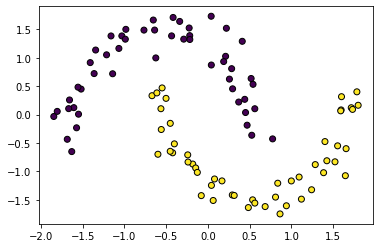

In [2]:
n_samples = 100
noise = 0.1
random_state = 0
shuffle = True

X, y = make_moons(
    n_samples=n_samples, random_state=random_state, noise=noise, shuffle=shuffle
)
X = StandardScaler().fit_transform(X)  # Yes, this is useful for GPs

X, y = map(jnp.array, (X, y))

plt.scatter(X[:, 0], X[:, 1], c=y);

## Methodology

To define a GP, we need a kernel function. Let us use the [RBF](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) or [Exponentiated Quadratic](https://www.cs.toronto.edu/~duvenaud/cookbook/#:~:text=%22Exponentiated%20Quadratic%22) or [Squared Exponential](http://gaussianprocess.org/gpml/chapters/RW.pdf) kernel.

In [3]:
lengthscale = 1.0
variance = 1.0

kernel_fn = variance * kernels.ExpSquared(scale=lengthscale)

kernel_fn(X, X).shape

(100, 100)

As explained in [the blog post](https://martiningram.github.io/scalable-gp/), we want to minimize the following loss function:

$$
KL[q(u|\eta) || p(u|y, \theta)] = KL[q(u|\eta) || p(u | \theta)] - \mathbb{E}_{u \sim q(u|\eta)} \log p(y | u, \theta) + const
$$

Let us break down the loss and discuss each componant.

### KL divergence

In the first term, we want to compute the KL divergence between prior and variational distribution of GP at inducing points. First, we need to define the inducing points.

In [4]:
key = jax.random.PRNGKey(0)
n_inducing = 10
n_dim = X.shape[1]

X_inducing = jax.random.normal(key, shape=(n_inducing, n_dim))
X_inducing.shape

(10, 2)

Now, defining the prior and variational distributions.

In [5]:
gp_mean = 0.43  # a scalar parameter to train

prior_mean = gp_mean * jnp.zeros(n_inducing)
prior_cov = kernel_fn(X_inducing, X_inducing)

prior_distribution = tfd.MultivariateNormalFullCovariance(prior_mean, prior_cov)

In [6]:
variational_mean = jax.random.uniform(key, shape=(n_inducing,)) # a vector parameter to train

A covariance matrix can not be learned directly due to positive definite constraint. We can decompose a covariance matrix in a following way:

$$
\begin{aligned}
K &= diag(\boldsymbol{\sigma})\Sigma diag(\boldsymbol{\sigma})\\
  &= diag(\boldsymbol{\sigma})LL^T diag(\boldsymbol{\sigma})
\end{aligned}
$$

Where, $\Sigma$ is a correlation matrix, $L$ is a lower triangular cholesky decomposition of $\Sigma$ and $\boldsymbol{\sigma}$ is the variance vector. We can use `tfb.CorrelationCholesky` to generate $L$ from a unconstrained vector:

In [7]:
random_vector = jax.random.normal(key, shape=(3,))
chol = tfb.CorrelationCholesky()(random_vector)
correlation = chol@chol.T
correlation

DeviceArray([[ 1.        ,  0.54464529, -0.7835968 ],
             [ 0.54464529,  1.        , -0.33059078],
             [-0.7835968 , -0.33059078,  1.        ]], dtype=float64)

To constrain $\boldsymbol{\sigma}$, any positivity constraint would suffice. So, combining these tricks, we can model the covariance as following:

In [8]:
random_vector = jax.random.normal(
    key, shape=(n_inducing * (n_inducing - 1) // 2,)
)  # a trainable parameter
log_sigma = jax.random.normal(key, shape=(n_inducing, 1))  # a trainable parameter


sigma = jnp.exp(log_sigma)
corr_chol = tfb.CorrelationCholesky()(random_vector)
variational_cov = sigma * sigma.T * (corr_chol @ corr_chol.T)
print(variational_cov.shape)

variational_distribution = tfd.MultivariateNormalFullCovariance(variational_mean, variational_cov
)

(10, 10)


Now, we can compute the KL divergence:

In [9]:
variational_distribution.kl_divergence(prior_distribution)

DeviceArray(416.89357355, dtype=float64)

### Expectation over the likelihood

We want to compute the following expectation:

$$
-\sum_{i=1}^N \mathbb{E}_{f_i \sim q(f_i | \eta, \theta)} \log p(y_i| f_i, \theta)
$$

Note that, $p(y_i| f_i, \theta)$ can be any likelihood depending upon the problem, but for classification, we may use a Bernoulli likelihood.

In [10]:
f = jax.random.normal(key, shape=y.shape)
likelihood_distribution = tfd.Bernoulli(logits=f)

log_likelihood = likelihood_distribution.log_prob(y).sum()
log_likelihood

DeviceArray(-72.04665624, dtype=float64)

We need to sample $f_i$ from $q(f_i | \eta, \theta)$ which has the following form:

$$
\begin{aligned}
q(f_i | \eta, \theta) &\sim \mathcal{N}(\mu_i, \sigma_i^2)\\
\mu_i &= Am\\
\sigma_i^2 &= K_{ii} + A(S - K_{mm})A^T\\
A &= K_{im}K_{mm}^{-1}
\end{aligned}
$$

Note that matrix inversion is often unstable and thus we will use cholesky tricks here to compute $A$.

In [11]:
def q_f(x_i):
    x_i = x_i.reshape(1, -1) # ensure correct shape
    K_im = kernel_fn(x_i, X_inducing)
    K_mm = kernel_fn(X_inducing, X_inducing)
    chol_mm = jnp.linalg.cholesky(K_mm + jnp.eye(K_mm.shape[0])*JITTER)
    A = jsp.linalg.cho_solve((chol_mm, True), K_im.T).T
    
    mu_i = A@variational_mean
    sigma_sqr_i = kernel_fn(x_i, x_i) + A@(variational_cov - prior_cov)@A.T
    
    return tfd.Normal(loc=mu_i, scale=sigma_sqr_i**0.5)

Here is a function to compute log likelihood for a single data-point:

In [12]:
def log_likelihood(x_i, y_i, seed):
    sample = q_f(x_i).sample(seed=seed)
    log_likelihood = tfd.Bernoulli(logits=sample).log_prob(y_i)
    return log_likelihood.squeeze()

In [13]:
log_likelihood(X[0], y[0], seed=key)

DeviceArray(-0.17831203, dtype=float64)

We can use `jax.vmap` to compute log_likelihood over a batch. We can leverage the stochastic variational inference following section 10.3.1 (Eq. 10.108) from [pml book2](https://probml.github.io/pml-book/book2.html). Ultimately, in each iteration, we need to multiply the batch log likelihood with $\frac{N}{B}$ to get an unbiased minibatch approximation where $N$ is size of the dataset and $B$ is batch size.

In [14]:
batch_size = 10

seeds = jax.random.split(key, num=batch_size)

ll = len(y)/batch_size * jax.vmap(log_likelihood)(X[:batch_size], y[:batch_size], seeds).sum()
ll

DeviceArray(-215.46520331, dtype=float64)

Note that, once the parameters are optimized, we can use the derivations of $q(f_i | \eta, \theta)$ to compute the posterior distribution. We have figured out all the pieces by now so it is the time to put it togather in a single class. Some pointers to note are the following:

* We define a single function `get_constrained_params` to transform all unconstrained parameters.
* `jax.lax.scan` gives a huge boost to a training loop.
* There is some repeatation of code due to lack of super code optimization. You can do it at your end if needed.

## All in one

In [15]:
class SVGP:
    def __init__(self, X_inducing, data_size):
        self.X_inducing = X_inducing
        self.n_inducing = len(X_inducing)
        self.data_size = data_size
        
    def init_params(self, seed):
        variational_corr_chol_param = tfb.CorrelationCholesky().inverse(jnp.eye(self.n_inducing))
        
        dummy_params = {"log_variance": jnp.zeros(()),
               "log_scale": jnp.zeros(()), 
               "mean": jnp.zeros(()),
               "X_inducing": self.X_inducing,
               "variational_mean": jnp.zeros(self.n_inducing),
               "variational_corr_chol_param": variational_corr_chol_param,
               "log_variational_sigma": jnp.zeros((self.n_inducing, 1)),
               }
        
        flat_params, unravel_fn = ravel_pytree(dummy_params)
        random_params = jax.random.normal(key, shape=(len(flat_params), ))
        params = unravel_fn(random_params)
        return params
    
    @staticmethod
    def get_constrained_params(params):
        return {"mean": params["mean"],
                "variance": jnp.exp(params['log_variance']), 
                "scale": jnp.exp(params['log_scale']), 
                "X_inducing": params["X_inducing"],
                "variational_mean": params["variational_mean"],
                "variational_corr_chol_param": params["variational_corr_chol_param"],
                "variational_sigma": jnp.exp(params["log_variational_sigma"])}
    
    @staticmethod
    def get_q_f(params, x_i, prior_distribution, variational_distribution):
        x_i = x_i.reshape(1, -1) # ensure correct shape
        
        kernel_fn = params['variance'] * kernels.ExpSquared(scale=params["scale"])
        K_im = kernel_fn(x_i, params["X_inducing"])
        K_mm = prior_distribution.covariance()
        chol_mm = jnp.linalg.cholesky(K_mm)
        A = jsp.linalg.cho_solve((chol_mm, True), K_im.T).T

        mu_i = A@params["variational_mean"]
        sigma_sqr_i = kernel_fn(x_i, x_i) + A@(variational_distribution.covariance() - K_mm)@A.T

        return tfd.Normal(loc=mu_i, scale=sigma_sqr_i**0.5)
    
    def get_distributions(self, params):
        kernel_fn = params['variance'] * kernels.ExpSquared(scale=params["scale"])
        prior_mean = params["mean"]
        prior_cov = kernel_fn(params["X_inducing"], params["X_inducing"]) + jnp.eye(self.n_inducing)*JITTER
        prior_distribution = tfd.MultivariateNormalFullCovariance(prior_mean, prior_cov)

        corr_chol = tfb.CorrelationCholesky()(params["variational_corr_chol_param"])
        sigma = jnp.diag(params["variational_sigma"])
        variational_cov = sigma*sigma.T*(corr_chol@corr_chol.T) + jnp.eye(self.n_inducing)*JITTER
        variational_distribution = tfd.MultivariateNormalFullCovariance(params["variational_mean"], variational_cov)
        
        return prior_distribution, variational_distribution
    
    def loss_fn(self, params, X_batch, y_batch, seed):
        params = self.get_constrained_params(params)
        
        # Get distributions
        prior_distribution, variational_distribution = self.get_distributions(params)
        
        # Compute kl
        kl = variational_distribution.kl_divergence(prior_distribution)

        # Compute log likelihood
        def log_likelihood_fn(x_i, y_i, seed):
            q_f = self.get_q_f(params, x_i, prior_distribution, variational_distribution)
            sample = q_f.sample(seed=seed)
            log_likelihood = tfd.Bernoulli(logits=sample).log_prob(y_i)
            return log_likelihood.squeeze()
        
        seeds = jax.random.split(seed, num=len(y_batch))
        log_likelihood = jax.vmap(log_likelihood_fn)(X_batch, y_batch, seeds).sum() * self.data_size/len(y_batch)

        return kl - log_likelihood
    
    def fit_fn(self, X, y, init_params, optimizer, n_iters, batch_size, seed):
        state = optimizer.init(init_params)
        value_and_grad_fn = jax.value_and_grad(self.loss_fn)
        
        def one_step(params_and_state, seed):
            params, state = params_and_state
            idx = jax.random.choice(seed, self.data_size, (batch_size,), replace=False)
            X_batch, y_batch = X[idx], y[idx]
            
            seed2 = jax.random.split(seed, 1)[0]
            loss, grads = value_and_grad_fn(params, X_batch, y_batch, seed2)
            updates, state = optimizer.update(grads, state)
            params = optax.apply_updates(params, updates)
            return (params, state), (loss, params)
        
        seeds = jax.random.split(seed, num=n_iters)
        (best_params, _), (loss_history, params_history) = jax.lax.scan(one_step, (init_params, state), xs=seeds)
        return best_params, loss_history, params_history

    def predict_fn(self, params, X_new):
        constrained_params = self.get_constrained_params(params)
        prior_distribution, variational_distribution = self.get_distributions(constrained_params)
        
        def _predict_fn(x_i):    
            # Get posterior
            q_f = self.get_q_f(constrained_params, x_i, prior_distribution, variational_distribution)
            return q_f.mean().squeeze(), q_f.variance().squeeze()
        
        mean, var = jax.vmap(_predict_fn)(X_new)
        return mean.squeeze(), var.squeeze()

## Train and predict

In [16]:
n_inducing = 20
n_epochs = 100
batch_size = 10
data_size = len(y)
n_iters = n_epochs*(data_size/batch_size)
n_iters

1000.0

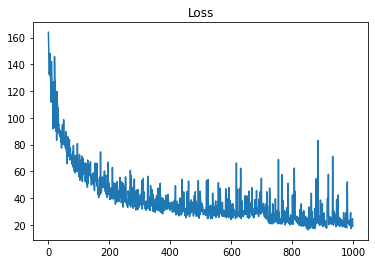

In [17]:
key = jax.random.PRNGKey(0)
key2, subkey = jax.random.split(key)
optimizer = optax.adam(learning_rate=0.01)

X_inducing = jax.random.choice(key, X, (n_inducing,), replace=False)
model = SVGP(X_inducing, data_size)

init_params = model.init_params(key2)

model.loss_fn(init_params, X, y, key)
best_params, loss_history, params_history = model.fit_fn(X, y, init_params, optimizer, n_iters, batch_size, subkey)

plt.figure()
plt.plot(loss_history);
plt.title("Loss");

In [18]:
x = jnp.linspace(-3.5, 3.5, 100)
seed = jax.random.PRNGKey(123)

X1, X2 = jnp.meshgrid(x, x)
f = lambda x1, x2: model.predict_fn(best_params, jnp.array([x1, x2]).reshape(1, -1))
pred_mean, pred_var = jax.vmap(jax.vmap(f))(X1, X2)
logits = tfd.Normal(pred_mean, pred_var**0.5).sample(seed=seed, sample_shape=(10000,))
proba = jax.nn.sigmoid(logits)

proba_mean = proba.mean(axis=0)
proba_std2 = proba.std(axis=0)*2

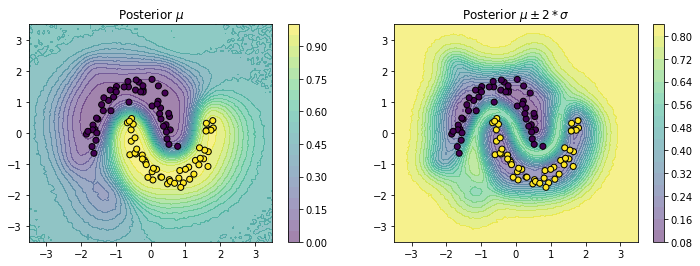

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
cplot1 = ax[0].contourf(X1, X2, proba_mean.squeeze(), alpha=0.5, levels=20)
plt.colorbar(cplot1, ax=ax[0])

cplot2 = ax[1].contourf(X1, X2, proba_std2.squeeze(), alpha=0.5, levels=20)
plt.colorbar(cplot2, ax=ax[1])

ax[0].scatter(X[:, 0], X[:, 1], c=y);
ax[1].scatter(X[:, 0], X[:, 1], c=y);

ax[0].set_title("Posterior $\mu$");
ax[1].set_title("Posterior $\mu \pm 2*\sigma$");

## Some more datasets

In [20]:
def fit_and_plot(X, y):
    X = StandardScaler().fit_transform(X)  # Yes, this is useful for GPs
    X, y = map(jnp.array, (X, y))

    X_inducing = jax.random.choice(key, X, (n_inducing,), replace=False)
    model = SVGP(X_inducing, data_size)

    init_params = model.init_params(key2)

    model.loss_fn(init_params, X, y, key)
    best_params, loss_history, params_history = model.fit_fn(X, y, init_params, optimizer, n_iters, batch_size, subkey)

    plt.figure()
    plt.plot(loss_history);
    plt.title("Loss");
    
    f = lambda x1, x2: model.predict_fn(best_params, jnp.array([x1, x2]).reshape(1, -1))
    pred_mean, pred_var = jax.vmap(jax.vmap(f))(X1, X2)
    logits = tfd.Normal(pred_mean, pred_var**0.5).sample(seed=seed, sample_shape=(10000,))
    proba = jax.nn.sigmoid(logits)

    proba_mean = proba.mean(axis=0)
    proba_std2 = proba.std(axis=0)*2
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    cplot1 = ax[0].contourf(X1, X2, proba_mean.squeeze(), alpha=0.5, levels=20)
    plt.colorbar(cplot1, ax=ax[0])

    cplot2 = ax[1].contourf(X1, X2, proba_std2.squeeze(), alpha=0.5, levels=20)
    plt.colorbar(cplot2, ax=ax[1])

    ax[0].scatter(X[:, 0], X[:, 1], c=y);
    ax[1].scatter(X[:, 0], X[:, 1], c=y);

    ax[0].set_title("Posterior $\mu$");
    ax[1].set_title("Posterior $\mu \pm 2*\sigma$");

### make_blobs

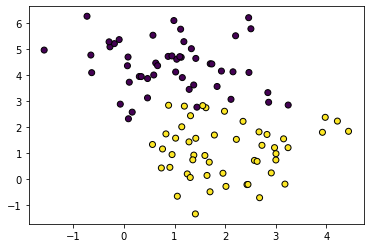

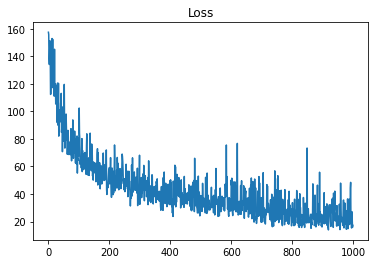

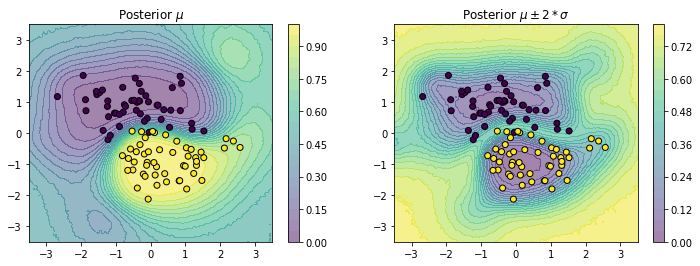

In [21]:
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=2)

plt.scatter(X[:, 0], X[:, 1], c=y);
fit_and_plot(X, y)

### make_circles

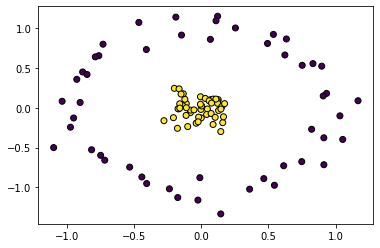

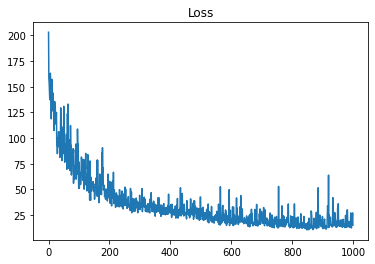

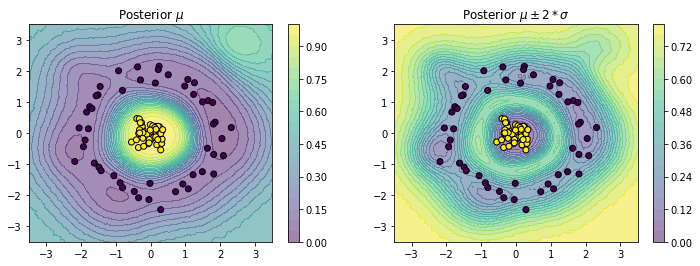

In [22]:
X, y = make_circles(n_samples=n_samples, random_state=random_state, noise=noise, factor=0.1)

plt.scatter(X[:, 0], X[:, 1], c=y);
fit_and_plot(X, y)